In [15]:
import pandas as pd
import os
import seaborn as sns
from config import *
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [16]:
result_dir='performance_prediction_results'

visualizations_dir='performance_prediction_visualizations'
algorithms='DE'
iteration_start,iteration_end=0,9
predict_log_precision=False
difference=False

seeds=[200,400,600,800,1000]

seed_mapping={index:seed for index,seed in enumerate(seeds)}

In [17]:
def get_global_file_name(dimension,algorithms, iteration_start,iteration_end, predict_log_precision,seed, difference):
    return os.path.join(result_dir,f'dim_{dimension}_{algorithms}_it_{iteration_start}-{iteration_end}_instance_count_99_seed_{seed}_log_{predict_log_precision}{"_differenced" if difference else ""}')


In [18]:
def get_predictions_df(dimension,algorithms, iteration_start, iteration_end, predict_log_precision,difference, seeds):
    test_df_all=pd.DataFrame()
    for train_seed in seeds:
        test_df=pd.DataFrame()
        for fold in range(0,10):

            global_file_name=get_global_file_name(dimension,algorithms, iteration_start,iteration_end, predict_log_precision,train_seed, difference)
            file_location=global_file_name+f'_fold_{fold}_test_preds.csv'

            if not os.path.isfile(file_location):
                print('Not found', file_location)
                continue
            #print(file_location)
            test_df_fold=pd.read_csv(file_location, index_col=[0], compression='zip')
            
            test_df_fold['fold']=fold
            test_df_fold['seed']=train_seed
            test_df=pd.concat([test_df,test_df_fold])
            test_df_all=pd.concat([test_df_all,test_df_fold])
    if test_df_all.shape[0]==0:
        return test_df_all
    if predict_log_precision:
        test_df_all['preds']=test_df_all['preds'].apply(lambda x: np.exp(x))
        test_df_all['y']=test_df_all['y'].apply(lambda x: np.exp(x))
    return test_df_all
    

In [19]:
def get_baseline(all_predictions):
    baselines=[]
    problem_ids=all_predictions['problem_id'].drop_duplicates()
    for problem_id in problem_ids:
        b=all_predictions.query('problem_id!=@problem_id').mean()['y']
        baselines+=[b]
    baseline_df=pd.DataFrame(baselines,index=problem_ids)
    baseline_df.columns=['baseline_preds']
    return baseline_df


In [20]:
def get_errors_for_algorithm(dimension,algorithm,start_iteration,end_iteration,predict_log_precision,difference,seeds):
    all_predictions = get_predictions_df(dimension,algorithm,0,end_iteration,predict_log_precision=predict_log_precision,difference=difference,seeds=seeds)

    dr_mae=mean_absolute_error(all_predictions['y'], all_predictions['preds'])
    dr_rmse=mean_squared_error(all_predictions['y'], all_predictions['preds'], squared=False)
    
    #mean_per_problem_class=all_predictions.groupby('problem_id').mean()['y']
    #all_predictions['baseline_preds']=all_predictions['problem_id'].apply(lambda p: mean_per_problem_class[p])
    
    baseline_df=get_baseline(all_predictions)
    all_predictions=all_predictions.merge(baseline_df, left_on='problem_id', right_on=baseline_df.index)
    
    
    baseline_mae=mean_absolute_error(all_predictions['y'], all_predictions['baseline_preds'])
    baseline_rmse=mean_squared_error(all_predictions['y'], all_predictions['baseline_preds'], squared=False)
    return algorithm, end_iteration+1, dr_mae,  baseline_mae,dr_rmse, baseline_rmse

Not found performance_prediction_results/dim_5_DE_it_0-39_instance_count_99_seed_200_log_False_fold_0_test_preds.csv
Not found performance_prediction_results/dim_5_DE_it_0-39_instance_count_99_seed_200_log_False_fold_1_test_preds.csv
Not found performance_prediction_results/dim_5_DE_it_0-39_instance_count_99_seed_200_log_False_fold_2_test_preds.csv
Not found performance_prediction_results/dim_5_DE_it_0-39_instance_count_99_seed_200_log_False_fold_3_test_preds.csv
Not found performance_prediction_results/dim_5_DE_it_0-39_instance_count_99_seed_200_log_False_fold_4_test_preds.csv
Not found performance_prediction_results/dim_5_DE_it_0-39_instance_count_99_seed_200_log_False_fold_5_test_preds.csv
Not found performance_prediction_results/dim_5_DE_it_0-39_instance_count_99_seed_200_log_False_fold_6_test_preds.csv
Not found performance_prediction_results/dim_5_DE_it_0-39_instance_count_99_seed_200_log_False_fold_7_test_preds.csv
Not found performance_prediction_results/dim_5_DE_it_0-39_instan

KeyError: 'y'

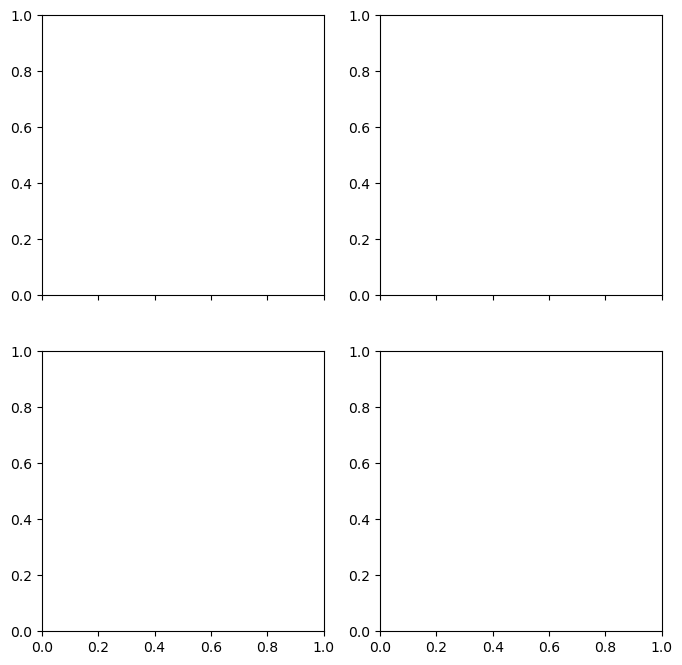

In [24]:
dimension=5
all_algorithms=['DE','CMAES','ES','PSO']
fig, axes = plt.subplots(int(len(all_algorithms)/2),2, figsize=(8,8), sharex=True)

for algorithm_index, algorithm in enumerate(all_algorithms):
    for predict_log_precision in [False]:
        
        for difference in [False]:
            errors_for_dimension=[]
            for end_iteration in [0,2,4,9,19,29,39,49]:
                errors_per_algorithm= get_errors_for_algorithm(dimension,algorithm,0,end_iteration=end_iteration,predict_log_precision=False,difference=False,seeds=seeds)
                errors_for_dimension+=[errors_per_algorithm]
                
            errors_for_dimension_df=pd.DataFrame(errors_for_dimension, columns=['algorithm', 'feature calculation budget (iterations)', 'DynamoRep MAE',  'Baseline MAE','DynamoRep RMSE', 'Baseline RMSE'])
            errors_for_dimension_df=errors_for_dimension_df.melt(id_vars=['algorithm','feature calculation budget (iterations)'], value_vars=['DynamoRep MAE',  'Baseline MAE','DynamoRep RMSE', 'Baseline RMSE'], value_name='performance')
            print(errors_for_dimension)
            
    ax=axes[int(algorithm_index/2), algorithm_index%2] if type(axes) is np.ndarray else axes
    ax.set_title(f'Algorithm: {algorithm}')
    g = sns.barplot(data=errors_for_dimension_df,x='feature calculation budget (iterations)', y="performance", hue="variable", palette=color_palette,ax=ax)
    if algorithm_index != 0:
        ax.get_legend().remove()
plt.tight_layout()
plt.show()
        

In [12]:
dimension=5

for algorithm in ['DE','ES','CMAES','PSO']:
    for predict_log_precision in [False]:
        for difference in [False]:
            for end_iteration in [9,19]:
                print(algorithm,'log:',predict_log_precision,'diff:',difference,'it:',end_iteration)
                
                all_predictions = get_predictions_df(dimension,algorithm,0,end_iteration,predict_log_precision=predict_log_precision,difference=difference,seeds=seeds)
                if all_predictions.shape[0]==0:
                    continue
                
                mean_per_problem_class=all_predictions.groupby('problem_id').mean()['y']
                baseline_df=get_baseline(all_predictions)
                all_predictions=all_predictions.merge(baseline_df, left_on='problem_id', right_on=baseline_df.index)
                #all_predictions['baseline_preds']=all_predictions['problem_id'].apply(lambda p: mean_per_problem_class[p])
                    
                for problem_id in range(1,25):
                    print('PID', problem_id)
                    problem_predictions=all_predictions.query('problem_id==@problem_id and instance_id==1')
                    print(mean_absolute_error(problem_predictions['y'], problem_predictions['preds']))
                    print(mean_squared_error(problem_predictions['y'], problem_predictions['preds'], squared=False))
                    print(mean_absolute_error(problem_predictions['y'], problem_predictions['baseline_preds']))
                    print(mean_squared_error(problem_predictions['y'], problem_predictions['baseline_preds'], squared=False))

DE log: False diff: False it: 9
PID 1
0.7714183837969228
0.8412148754210178
140.727334143337
140.72733414333706
PID 2
1392.8157771991653
1537.4913816702206
140.69782640254985
140.6978289198086
PID 3
7.71791632996838
7.74585479760458
140.04256329822323
140.04285159050806
PID 4
0.4151360169025306
0.5738069462340801
139.13284294410462
139.1333945027429
PID 5
20.244443565741022
25.64448553440355
140.72734032390912
140.72734032390915
PID 6
1.5862203938199686
1.8727553835111324
139.34104005524136
139.3422325054336
PID 7
8.056285012010143
8.52315002343241
139.78989696632107
139.7902452288205
PID 8
2.7755393070442986
3.5870693562806486
137.3796179518858
137.38691768308203
PID 9
24.282427354885414
49.4511023266464
137.0339453347921
137.0356770885584
PID 10
1158.8580208893088
1389.7745870242209
1070.2335475748803
1316.8399699665083
PID 11
13.893406570056166
15.579453235131474
125.39211398325797
125.58411311154613
PID 12
562.2792411017904
595.5592720057729
507.01588032175243
543.6791445023332
PID